## In this notebook we create our model and evaluate it

**Model Steps:**

1. Run PCA on the preprocessed data

2. Use the elbow method to find a k value

3. Run kmeans with the dataframe created in the PCA step



# Set up and load data

In [1]:
!pip install --quiet pyarrow polars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.6/783.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 39.2 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import sklearn as skl
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.metrics import silhouette_score

RANDOM_STATE = 42

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
processed_users_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_df_encoded.parquet"
users_pq = pl.read_parquet(processed_users_path)

In [5]:
users_df_pl = pl.DataFrame(users_pq)

In [6]:
# This conversion can take 51s on regular ram, 21 seconds on high ram mode
users_df = users_df_pl.to_pandas(use_pyarrow_extension_array=True)

In [7]:
# Drop all one hot encoded fav artist columns (takes too long to run)
users_df_genre = users_df[users_df.columns.drop(list(users_df.filter(regex='fav_artist_')))]

# PCA
Run PCA and capture at least 90% of the variance.

In [8]:
# Want to keep at least 90% of the variance
transformer = PCA(n_components=0.9, random_state=RANDOM_STATE)

In [9]:
# Drop user_id as it has no relevance for clustering
X = users_df_genre.drop(columns=['user_id'])

In [10]:
X_pca = transformer.fit_transform(X)

In [11]:
# Create new columns for each of the components
num_cols = X_pca.shape[1]
X_pca_df = pd.DataFrame(
    X_pca,
    columns=[f'PC{i + 1}' for i in range(num_cols)]
)
X_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-2.792379,0.132377,1.281681,0.346222,-0.255356,0.216772
1,-1.566228,1.404908,-0.655495,0.767199,0.121842,-0.193491
2,-3.214255,0.076619,-2.350234,-4.964179,-0.029873,-0.262177
3,-1.996790,-0.625190,-0.052109,1.067431,0.411595,-0.030330
4,-1.605612,-0.813201,1.130148,0.569297,0.688310,0.221284


In [12]:
print("Explained variance ratio by each component:", transformer.explained_variance_ratio_)
print("Total variance captured:", np.sum(transformer.explained_variance_ratio_))

Explained variance ratio by each component: [0.45563277 0.27770974 0.06589831 0.05703016 0.03833838 0.02803732]
Total variance captured: 0.9226466755159359


# Elbow method
Use elbow method and a plot to see how many clusters we should use.

In [13]:
n_clusters = 30
k_values = range(1, n_clusters + 1)
inertia_values = []
kmeans_comp_arr = np.zeros((n_clusters,n_clusters))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    kmeans_fitted = kmeans.fit(X_pca_df)
    inertia_values.append(kmeans.inertia_)
    cluster_id, counts = np.unique(kmeans_fitted.labels_, return_counts=True)
    # print(cluster_id,counts)
    for i in range(len(cluster_id)):
      kmeans_comp_arr[k-1,cluster_id[i]] = counts[i]


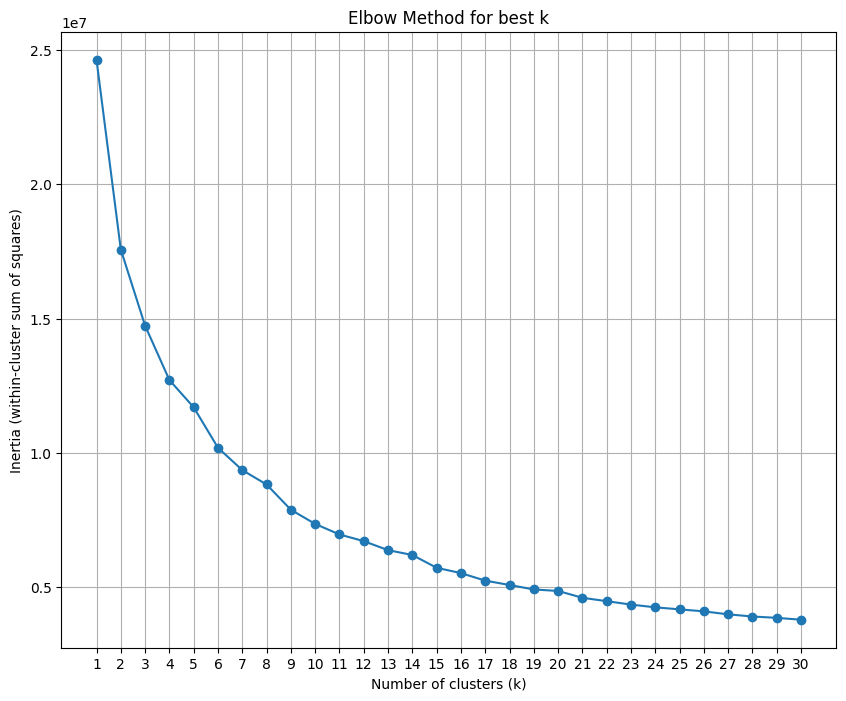

In [14]:
# Plot the elbow
plt.figure(figsize=(10, 8))
plt.plot(k_values, inertia_values, marker='o')
plt.xticks(k_values)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.title('Elbow Method for best k')
plt.grid(True)
plt.show()

In [16]:
kmeans_comp_df = pd.DataFrame(kmeans_comp_arr.T, index=k_values, columns=k_values)
kmeans_comp_df['cluster_id'] = kmeans_comp_df.index

column_to_move = 'cluster_id'
col_data = kmeans_comp_df.pop(column_to_move)
kmeans_comp_df.insert(0, column_to_move, col_data)
kmeans_comp_df.head(10)

,cluster_id,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
1,1,964675.0,844278.0,836403.0,726953.0,103784.0,102401.0,528904.0,568787.0,531864.0,...,333391.0,313269.0,259535.0,254384.0,252459.0,245557.0,247871.0,244125.0,229653.0,222969.0
2,2,0.0,120397.0,91828.0,26554.0,23596.0,22133.0,11464.0,33941.0,21201.0,...,49171.0,46429.0,45067.0,46880.0,46280.0,25833.0,55259.0,25821.0,47070.0,38455.0
3,3,0.0,0.0,36444.0,22979.0,169616.0,147882.0,73941.0,49363.0,50414.0,...,7450.0,5133.0,5056.0,5077.0,4648.0,4539.0,4016.0,3527.0,2698.0,2973.0
4,4,0.0,0.0,0.0,188189.0,644203.0,635192.0,224521.0,2582.0,1786.0,...,58656.0,67228.0,63521.0,59620.0,58856.0,59506.0,17220.0,17334.0,15232.0,25267.0
5,5,0.0,0.0,0.0,0.0,23476.0,55552.0,28532.0,162978.0,152081.0,...,26.0,26.0,26.0,24.0,24.0,24.0,24.0,20.0,22.0,22.0
6,6,0.0,0.0,0.0,0.0,0.0,1515.0,501.0,138847.0,103785.0,...,1662.0,1610.0,1583.0,848.0,987.0,996.0,916.0,378.0,775.0,759.0
7,7,0.0,0.0,0.0,0.0,0.0,0.0,96812.0,74.0,62.0,...,98896.0,92119.0,86821.0,91817.0,93242.0,90622.0,87842.0,91513.0,85681.0,85226.0
8,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8103.0,8150.0,...,133559.0,140056.0,130418.0,124669.0,122685.0,115327.0,118791.0,112891.0,116746.0,115009.0
9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95332.0,...,47270.0,46758.0,44367.0,43922.0,43759.0,43607.0,43642.0,43559.0,43317.0,43388.0
10,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31624.0,29740.0,28340.0,34330.0,11590.0,13959.0,11095.0,15929.0,12091.0,9476.0


<Figure size 1500x800 with 0 Axes>

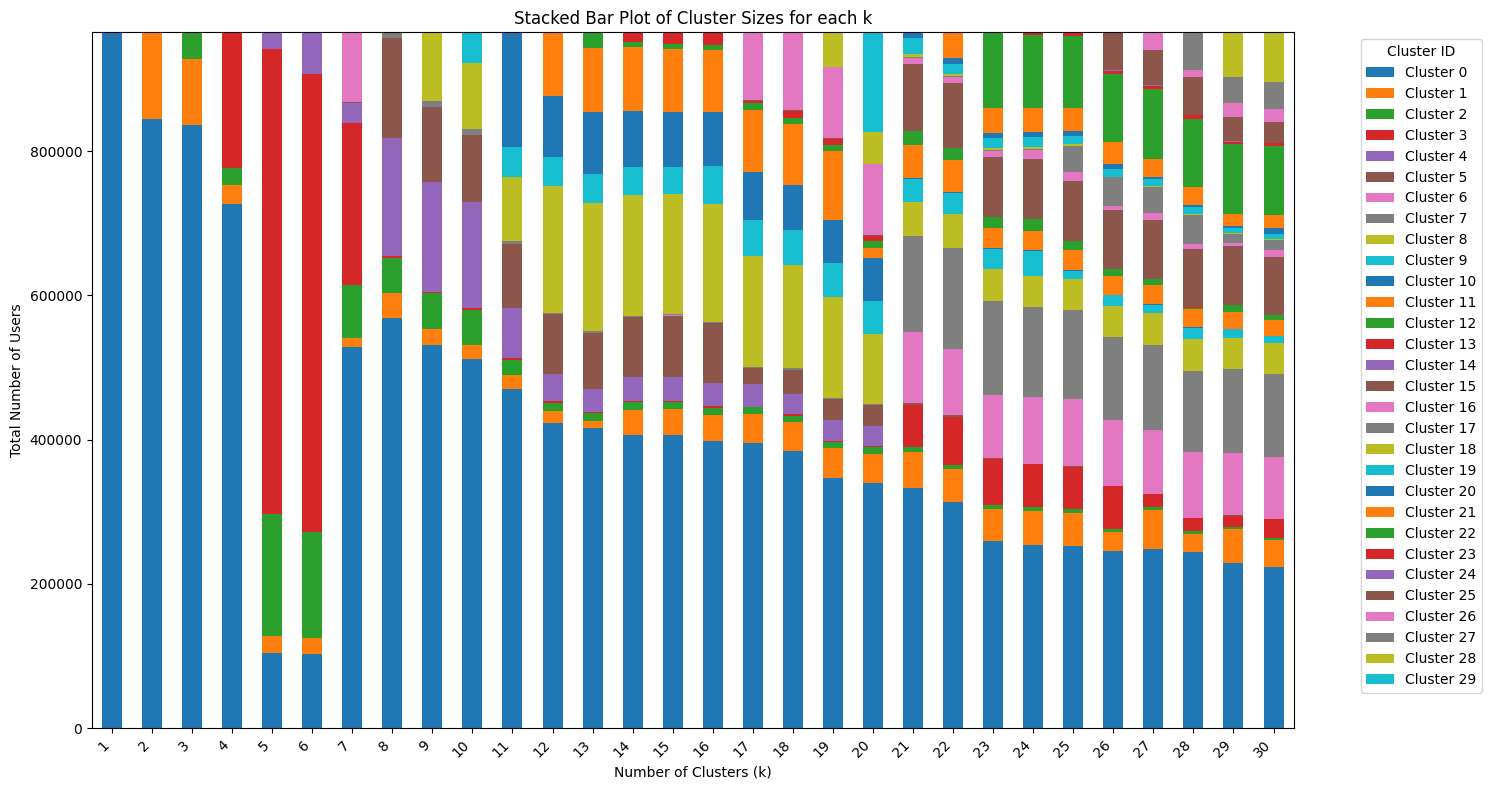

In [17]:
# Create a DataFrame where index is k_value and columns are cluster IDs
df_for_stacked_plot = pd.DataFrame(kmeans_comp_arr,
                                   index=k_values,
                                   columns=[f'Cluster {i}' for i in range(n_clusters)])

plt.figure(figsize=(15, 8))
df_for_stacked_plot.plot(kind='bar', stacked=True, figsize=(15, 8))#, colormap='Set2')
plt.title('Stacked Bar Plot of Cluster Sizes for each k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Total Number of Users')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

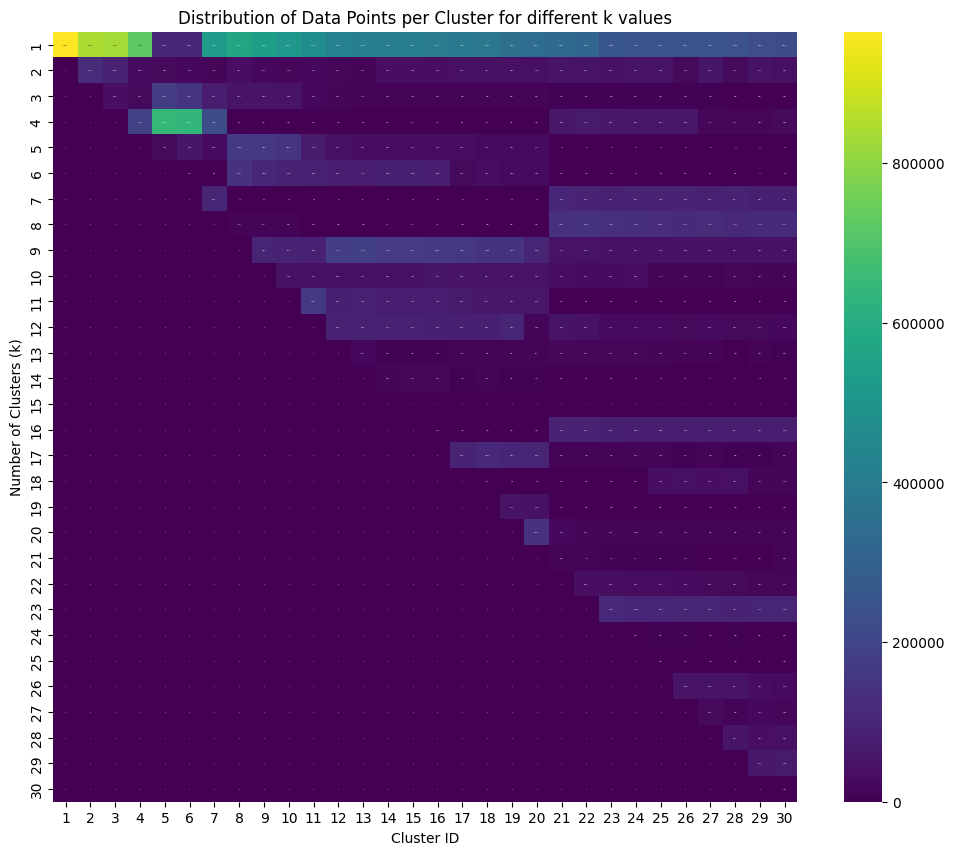

In [18]:
plt.figure(figsize=(12, 10))
sns.heatmap(kmeans_comp_df.drop(columns='cluster_id'), annot=True, fmt='g', annot_kws={'fontsize': 0.1}, cmap='viridis')
plt.title('Distribution of Data Points per Cluster for different k values')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Clusters (k)')
plt.show()

# K Means Clustering

In [19]:
# Based on the graph we see it levels off around 9
k_num_clusters = 9

In [20]:
kmeans = KMeans(n_clusters=k_num_clusters, random_state=RANDOM_STATE, n_init='auto')
kmeans_fitted = kmeans.fit(X_pca_df)
inertia_values.append(kmeans.inertia_)
np.unique(kmeans_fitted.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32),
 array([531864,  21201,  50414,   1786, 152081, 103785,     62,   8150,
         95332]))

# Model Evaluation

In [21]:
# Compute Silhouette Score to measure cluster similarity
# It's too costly with the whole dataset so we sample with 50k
sample = np.random.choice(len(X_pca_df), size=50000, replace=False)
score = silhouette_score(X_pca_df.iloc[sample], kmeans_fitted.labels_[sample])
print("Silhouette Score (sample):", score)

Silhouette Score (sample): 0.33638476974760023


In [22]:
# For PCA Plots
users_columns_pca = X_pca_df.columns
users_centroids_pca = kmeans_fitted.cluster_centers_
users_kmeans_centroids_df = pd.DataFrame(columns=users_columns_pca, data=users_centroids_pca)
users_kmeans_centroids_df['cluster_id'] = users_kmeans_centroids_df.index

users_df_clusters = X_pca_df.copy()
users_df_clusters['cluster_id'] = kmeans_fitted.labels_
users_df_clusters['user_id'] = users_df_genre['user_id']

In [23]:
users_kmeans_centroids_df

,PC1,PC2,PC3,PC4,PC5,PC6,cluster_id
0,-1.685067,0.010622,-0.026739,0.445571,0.014231,-0.019247,0
1,7.052056,7.142644,-0.073248,-0.001631,-0.490875,0.598797,1
2,7.223356,-3.582164,0.044336,-0.152687,0.053117,0.084546,2
3,20.339931,25.818019,-0.110597,-0.391158,2.120299,-1.746508,3
4,1.664019,-1.480048,-0.039280,0.234225,0.198092,-0.078468,4
5,1.302730,2.379416,0.223217,0.260966,-0.260364,0.225652,5
6,84.491103,121.684163,-4.066449,-2.021271,19.709632,-18.049706,6
7,18.334147,-9.770951,0.256760,-0.993579,-0.035025,-0.728228,7
8,-2.068504,0.281951,-0.055774,-2.969088,-0.079845,-0.084838,8


In [24]:
# For visualizing using original features
users_df_clusters_orig = users_df_genre.copy()
users_df_clusters_orig['cluster_id'] = kmeans_fitted.labels_
users_df_clusters_orig['user_id'] = users_df_genre['user_id']

In [25]:
users_df_clusters['cluster_id'].value_counts().sort_index()

,count
cluster_id,
0,531864
1,21201
2,50414
3,1786
4,152081
5,103785
6,62
7,8150
8,95332


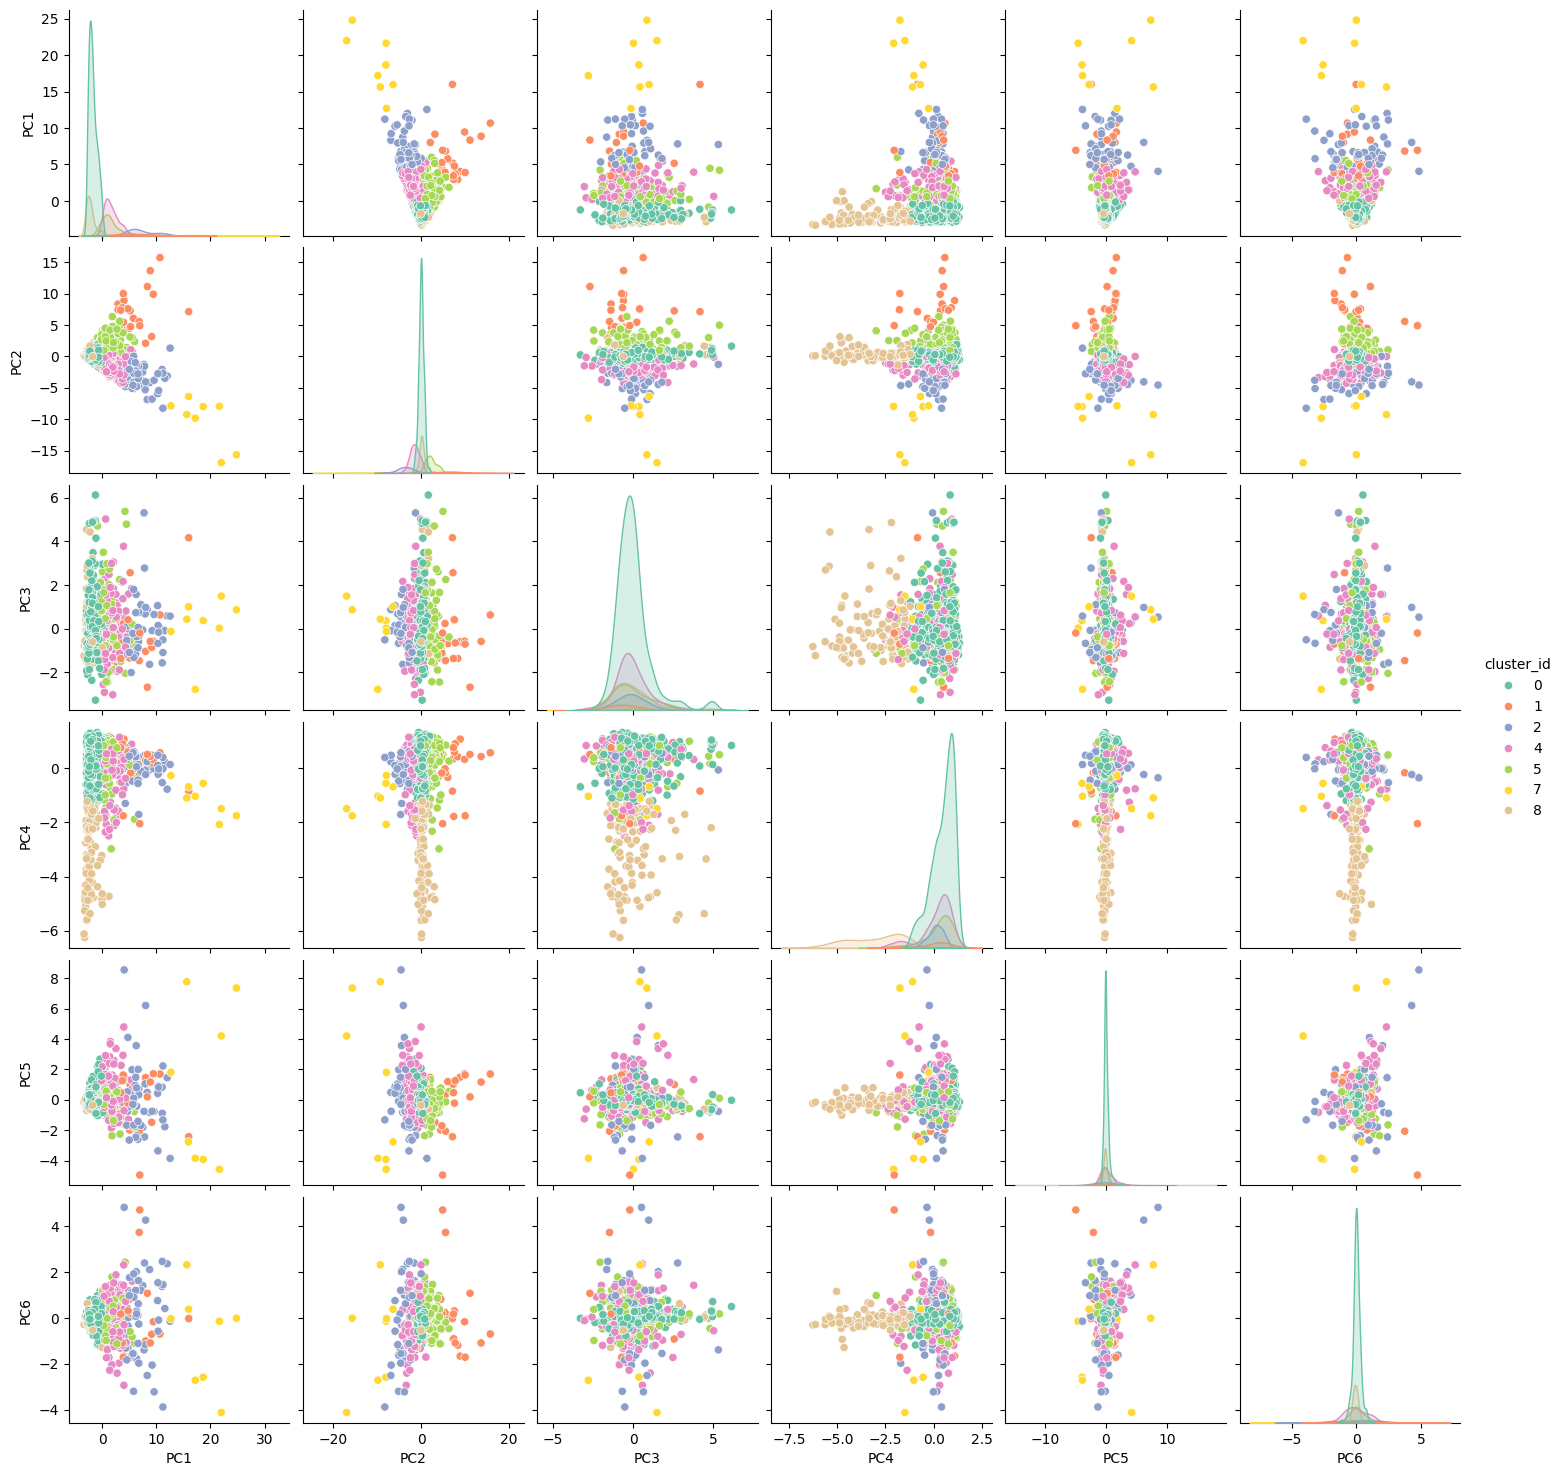

In [26]:
# How are clusters distinguished across different PC features
sns.pairplot(
    hue='cluster_id',
    palette='Set2',
    data=users_df_clusters.sample(n=1000, random_state=RANDOM_STATE)
)

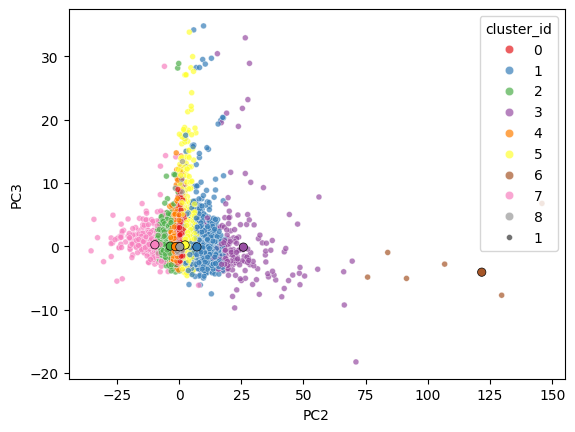

In [27]:
# Inspect a designated pc space more closely (look at pairplots for general overview)
# Also shows the centroids
variable_pairs = ['PC2', 'PC3']

#plotting the results
sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='cluster_id',
    palette='Set1',
    size=1, alpha=0.7,
    data=users_df_clusters.sample(n=100000, random_state=RANDOM_STATE)
)

sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='cluster_id',
    palette='Set1',
    markers=1000,
    alpha=1,
    edgecolor="black",
    data=users_kmeans_centroids_df,
    legend=False
)
plt.show()

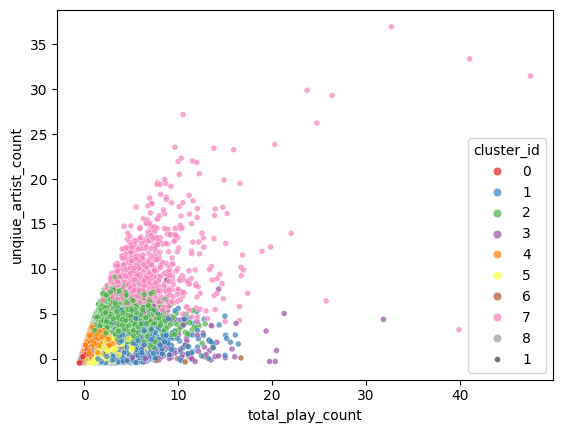

In [30]:
# To show that our current model is not separating just on play count and play time
# We can see this because it is not neatly separated on these 2 features alone (like it was with just numerical values)
variable_pairs = ['total_play_count', 'unqiue_artist_count']
# Plotting the results
sns.scatterplot(
    x=variable_pairs[0],
    y=variable_pairs[1],
    hue='cluster_id',
    palette='Set1',
    size=1, alpha=0.7,
    data=users_df_clusters_orig.sample(n=100000, random_state=RANDOM_STATE)
)
plt.show()

# Playlist Generation

In [31]:
songs_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/songs_df_full.csv"
songs_df = pd.read_csv(songs_path)

In [32]:
users_songs_clusters = pd.merge(songs_df, users_df_clusters, on='user_id')
users_songs_clusters = users_songs_clusters.drop(
    columns=["track_id", "artist_id", "artist_mbid", "shs_perf", "shs_work",
             "track_7digitalid", 'PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6'])

In [33]:
users_songs_clusters.head(5)

,user_id,song_id,plays,title,release,artist_name,duration,artist_familiarity,artist_hotttnesss,year,majority_genre,minority_genre,tot_track_time,cluster_id
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,112.63955,0.832012,0.677482,0,Rock,Folk,112.63955,4
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,Nothing from Nothing,To Die For,Billy Preston,153.59955,0.580555,0.482492,1974,RnB,NaN,153.59955,4
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,358.24281,0.633119,0.417718,1976,Electronic,Metal,716.48562,4
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,Under Cold Blue Stars,Under Cold Blue Stars,Josh Rouse,266.34404,0.675339,0.509058,2002,Rock,NaN,266.34404,4
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1,Riot Radio (Soundtrack Version),Nick & Norah's Infinite Playlist - Original Mo...,The Dead 60s,141.42649,0.650281,0.451749,0,NaN,NaN,141.42649,4


In [34]:
# Group and sort in descending order
usc = users_songs_clusters.groupby(['cluster_id', 'song_id'])['plays'].count().sort_values(ascending=False)

In [35]:
# Top 10 songs per cluster
top_10_per_cluster = usc.groupby(level='cluster_id').head(10)

In [36]:
# Convert the top_10_per_cluster Series to a DataFrame
top_10_df = top_10_per_cluster.reset_index()
# Select relevant columns from users_songs_clusters
song_details_cols = ['cluster_id', 'song_id', 'title', 'release', 'artist_name', 'duration', 'artist_familiarity',
                     'artist_hotttnesss',  'tot_track_time']
users_songs_details = users_songs_clusters[song_details_cols]
# Merge with users_songs_details to get song details
top_songs_details = pd.merge(top_10_df, users_songs_details, on=['cluster_id', 'song_id'], how='left')
# Drop duplicate rows that might arise from the merge (keeping the first occurrence)
top_songs_details = top_songs_details.drop_duplicates(subset=['cluster_id', 'song_id'], keep='first')
# Display the resulting DataFrame
display(top_songs_details.head())

,cluster_id,song_id,plays,title,release,artist_name,duration,artist_familiarity,artist_hotttnesss,tot_track_time
0,0,SOFRQTD12A81C233C0,20876,Sehr kosmisch,Musik von Harmonia,Harmonia,655.77751,0.505949,0.848826,1967.33253
20876,0,SOAUWYT12A81C206F1,16195,Undo,Vespertine Live,Björk,348.57751,0.853154,0.588209,697.15502
37071,0,SOAXGDH12A8C13F8A1,15224,Dog Days Are Over (Radio Edit),Now That's What I Call Music! 75,Florence + The Machine,219.66322,0.818804,0.759102,439.32644
52295,0,SOBONKR12A58A7A7E0,13952,You're The One,If There Was A Way,Dwight Yoakam,239.30730,0.775370,0.514569,478.61460
66247,0,SONYKOW12AB01849C9,13558,Secrets,Waking Up,OneRepublic,224.67873,0.744410,0.792048,449.35746


In [37]:
users_songs_clusters['cluster_id'].value_counts()


,count
cluster_id,
0,5149591
4,5138309
2,3640087
5,1607427
7,1316311
8,804158
1,524730
3,43778
6,1004


In [38]:
cluster_totals = users_songs_clusters.groupby('cluster_id').agg(
    total_plays=('plays', 'sum'),
    total_track_time=('tot_track_time', 'sum')
)

unique_users_per_cluster = users_df_clusters.groupby('cluster_id')['user_id'].nunique()
unique_users_per_cluster = users_df_clusters.groupby('cluster_id')['user_id'].nunique()

avg_plays_per_user = cluster_totals['total_plays'] / unique_users_per_cluster

avg_tot_track_time_per_user = cluster_totals['total_track_time'] / unique_users_per_cluster

cluster_summary_df = pd.DataFrame({
    'unique_users': unique_users_per_cluster,
    'total_plays': cluster_totals['total_plays'],
    'total_track_time': cluster_totals['total_track_time'],
    'avg_plays_per_user': avg_plays_per_user,
    'avg_total_track_time_per_user': avg_tot_track_time_per_user
})
display(cluster_summary_df)

,unique_users,total_plays,total_track_time,avg_plays_per_user,avg_total_track_time_per_user
cluster_id,,,,,
0,531864,11733162,2.903988e+09,22.060455,5460.020715
1,21201,4577100,1.156829e+09,215.890760,54564.849157
2,50414,9339472,2.314504e+09,185.255524,45909.946849
3,1786,624470,1.609802e+08,349.647256,90134.503662
4,152081,11692211,2.889822e+09,76.881471,19001.863278
5,103785,9166738,2.305389e+09,88.324305,22213.119099
6,62,38122,1.033427e+07,614.870968,166681.744057
7,8150,3072112,7.595054e+08,376.946258,93190.845824
8,95332,1951050,4.850569e+08,20.465846,5088.080526


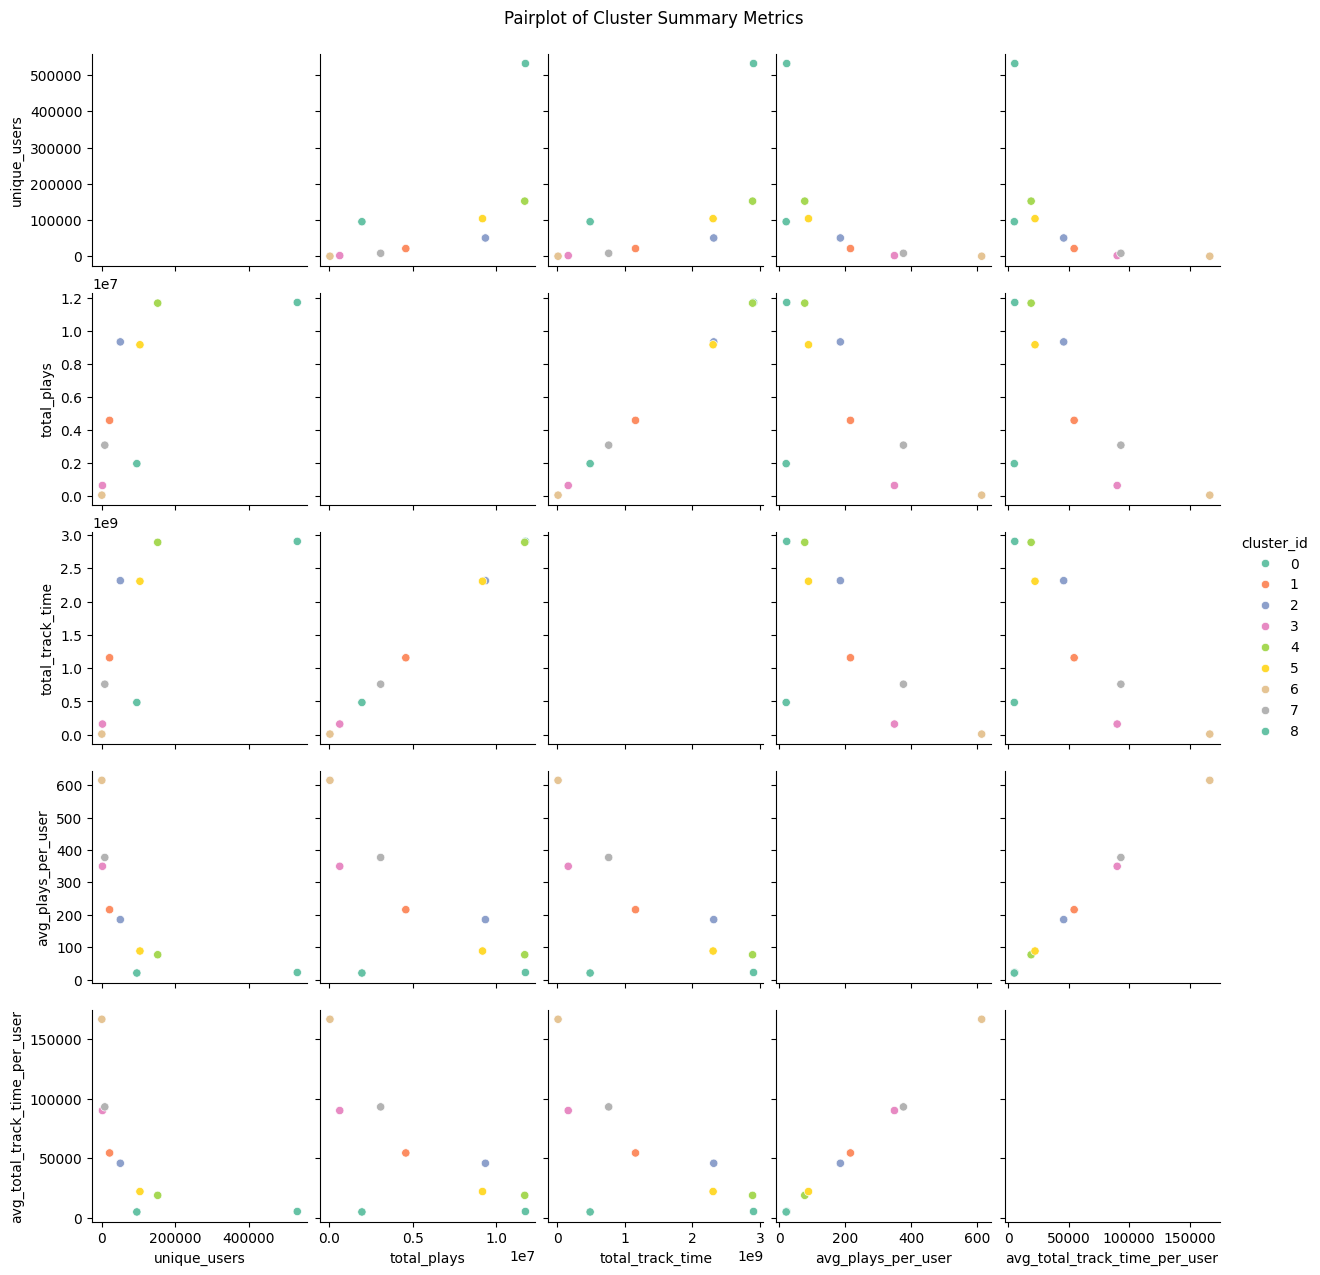

In [39]:
cluster_summary_df_plot = cluster_summary_df.reset_index()
sns.pairplot(cluster_summary_df_plot, hue='cluster_id', palette='Set2')
plt.suptitle('Pairplot of Cluster Summary Metrics', y=1.02)
plt.show()